### Check to see if notebook is running on Google Colab

In [2]:
import sys

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append('/content/gdrive/MyDrive/abm')
    data_dir       = '/content/gdrive/MyDrive/abm/data/'
    figure_dir     = '/content/gdrive/MyDrive/abm/figures/'
    ! pip install mesa seaborn tqdm matplotlib gpy --quiet
else:
    data_dir    = '../data/'
    figure_dir  = '../figures/'


In [3]:
import numpy as np
import pandas as pd
import pickle

from abmlib import *
from emulators import *

import matplotlib.pyplot as plt

# Packaging data

In [4]:
dataset_names = [
    'couzin',
    'sir',
    'kauffman'
]

data = {x:{} for x in dataset_names}

fancy_names = {
    'couzin'   : 'Couzin model',
    'sir'      : 'SIR model',
    'kauffman' : 'Kauffman model' 
}

### Loading Couzin data

In [3]:
var_to_use = 'dir'

for vn in ['rho', 'dir']:
    data['couzin'][f'time_series_group_{vn}'] =  pd.read_csv(data_dir + f'couzin_tseries_group_{vn}.csv').values
    
data['couzin']['params'] = pd.read_csv(data_dir + f'couzin_tseries_params.csv').values
data['couzin']['timeseries'] = data['couzin'][f'time_series_group_{var_to_use}']
data['couzin']['static'] = data['couzin'][f'time_series_group_{var_to_use}']

### Loading SIR data

In [5]:
sir_thin_factor = 15

# Specify parameters that are not held constant over different
# ABM runs
sir_params_varying = [
    'ptrans',
    'death_rate',
    'pcure',
    'p_infected_initial_log10',
    'pdoctor_log10'
]

data['sir']['params'] = pd.DataFrame(pickle.load(open(data_dir + f'/sir/input_dicts.pkl','rb')))
data['sir']['params'] = data['sir']['params'][sir_params_varying].iloc[::sir_thin_factor].values

n_blocks = 78
blocks   = [pickle.load(open(data_dir + f'/sir/sir_states_{i}.pkl','rb')) for i in range(n_blocks)]

for sn in ['all_states', 'doctor_states']:
    data['sir'][sn] = np.concatenate([x[sn] for x in blocks], axis=0)
    
data['sir']['timeseries'] = data['sir']['all_states'][::sir_thin_factor,...,1]
data['sir']['static']     = np.argmax(data['sir']['timeseries'], axis=1)

In [12]:
blocks[0]['all_states']

array([[[10000,     0,     0],
        [10000,     0,     0],
        [10000,     0,     0],
        ...,
        [10000,     0,     0],
        [10000,     0,     0],
        [10000,     0,     0]],

       [[ 9999,     1,     0],
        [ 9999,     1,     0],
        [ 9999,     1,     0],
        ...,
        [ 9999,     0,     1],
        [ 9999,     0,     1],
        [ 9999,     0,     1]],

       [[ 9999,     1,     0],
        [ 9999,     1,     0],
        [ 9999,     1,     0],
        ...,
        [ 9999,     0,     1],
        [ 9999,     0,     1],
        [ 9999,     0,     1]],

       ...,

       [[ 9956,    43,     1],
        [ 9956,    43,     1],
        [ 9956,    43,     1],
        ...,
        [ 9956,     0,    44],
        [ 9956,     0,    44],
        [ 9956,     0,    44]],

       [[ 9949,    51,     0],
        [ 9949,    51,     0],
        [ 9949,    51,     0],
        ...,
        [ 9949,     0,    51],
        [ 9949,     0,    51],
        [ 9949,

In [8]:
data['sir']['all_states'].shape

(7776, 80, 3)

In [5]:
permutation = np.random.permutation(np.arange(data['sir']['static'].shape[0]))

for k in ['params','timeseries','static']:
    data['sir'][k] = data['sir'][k][permutation]


### Loading Kauffman network data

In [6]:
df = pd.read_csv(data_dir+'kauffman_tseries_params.csv' )

data['kauffman']['params']     = df[['p','k']].values
data['kauffman']['timeseries'] = pd.read_csv(data_dir + '/kauffman_tseries.csv').values
data['kauffman']['static']     = data['kauffman']['timeseries'][...,-1]


# Fitting emulators

In [7]:
constants = {x:{} for x in dataset_names}
training_fraction = 0.75


#### Dynamic case


In [8]:
emulators             = {}

stk_predictions       = {x:{} for x in dataset_names}
stk_predictions_train = {x:{} for x in dataset_names}
ind_predictions       = {x:{} for x in dataset_names}
ind_predictions_train = {x:{} for x in dataset_names}


xy_values       = {}

for ds in dataset_names:
    print(f'Fitting model and generating predictions for {ds}')
    # Standardize all inputs and response variables
    outputs = np.log10(data[ds]['timeseries']+1)
    n_steps = outputs.shape[-1]

    outputs_means  = outputs.mean()
    outputs_scales = outputs.std()
    outputs_std    = (outputs-outputs_means) / outputs_scales
    constants[ds]['output_scale'] = outputs_scales
    constants[ds]['output_mean']  = outputs_means

    inputs        = data[ds]['params']
    inputs_means  = inputs.mean()
    inputs_scales = inputs.std()
    inputs_std    = (inputs-inputs_means) / inputs_scales
    constants[ds]['param_scale'] = inputs.std()
    constants[ds]['param_mean']  = inputs.mean()
    
    indices = np.arange(len(outputs_std))
    np.random.shuffle(indices)
    train_cutoff = int(training_fraction*len(outputs_std))
    is_train, is_test = indices[:train_cutoff], indices[train_cutoff:]
    constants[ds]['is_train'] = is_train
    
    X_train, X_test = inputs[is_train], inputs[is_test]
    Y_train, Y_test = outputs_std[is_train], outputs_std[is_test]
    
    xy_values[ds] = X_train,X_test,Y_train,Y_test
    kron_Xs_train = [inputs_std[is_train], np.arange(n_steps)[:, None]]
    kron_Xs_test  = [inputs_std[is_test], np.arange(n_steps)[:, None]]
    
    n_test, nx = kron_Xs_test[0].shape
    n_train, _ = kron_Xs_train[0].shape

    stk = SpaceTimeKronGPy(n_spatial_dims=kron_Xs_train[0].shape[1])

    stk.fit(kron_Xs_train[0],kron_Xs_train[1],Y_train)
    emulators[ds] = {}
    emulators[ds]['stk'] = stk
    
    stk_predictions_train[ds] = [x.reshape(n_train,n_steps, order='F') for x in stk.predict(kron_Xs_train[0], kron_Xs_train[1])]
    stk_predictions[ds]       = [x.reshape(n_test,n_steps, order='F') for x in stk.predict(kron_Xs_test[0], kron_Xs_test[1])]
    
    indgp = SpaceTimeIndependentGPy(n_spatial_dims=kron_Xs_train[0].shape[1])
    indgp.fit(kron_Xs_train[0], kron_Xs_train[1], Y_train)
    
    ind_predictions_train[ds] = indgp.predict(kron_Xs_train[0], kron_Xs_train[1])
    ind_predictions[ds]       = indgp.predict(kron_Xs_test[0], kron_Xs_test[1])
    
    emulators[ds]['ind'] = indgp

Fitting model and generating predictions for couzin
Fitting model and generating predictions for sir
Fitting model and generating predictions for kauffman


### ST-Kronecker plots

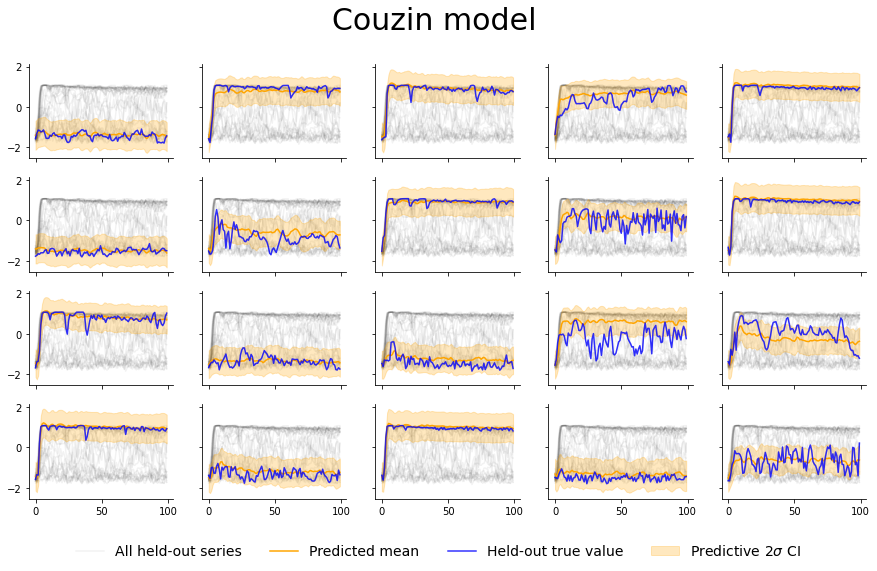

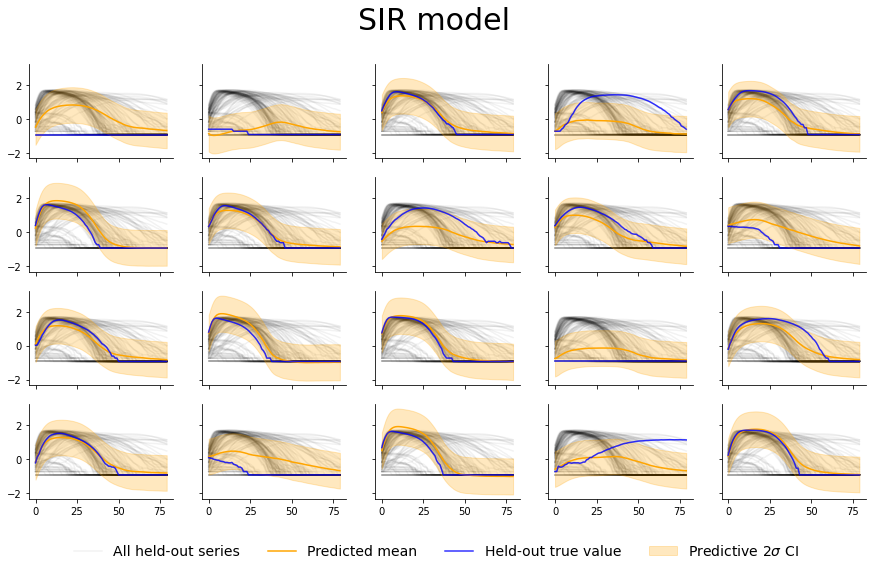

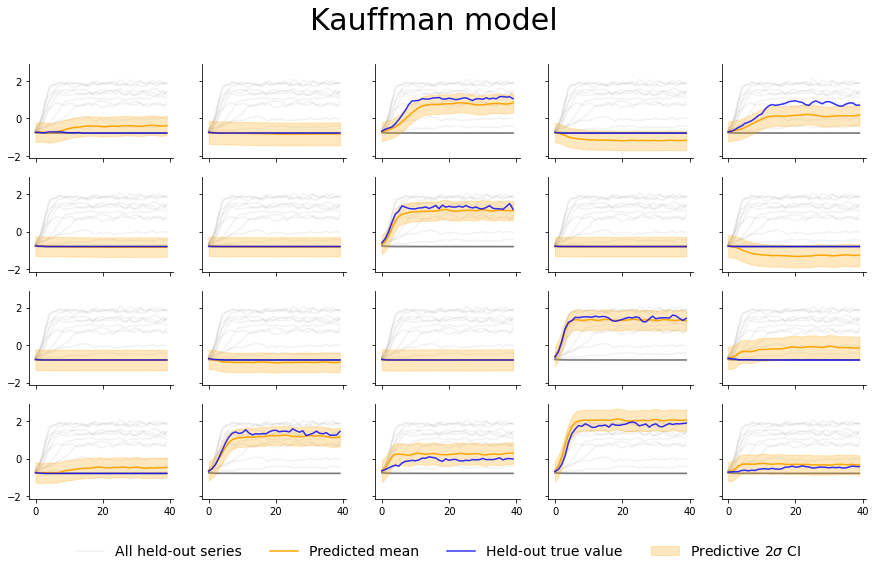

In [9]:
pred_color = 'orange'
test_color = 'b'

nrows = 4
ncols = 5

nsigma = 2

for ds in dataset_names:

    fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=True, figsize=(ncols*3, nrows*2))
    axes      = axes.ravel()
    plt.suptitle(fancy_names[ds], fontsize=30)
    
    pred_mean,       pred_var       = stk_predictions[ds]
    pred_mean_train, pred_var_train = stk_predictions_train[ds]

    _, _, Y_train, Y_test     = xy_values[ds]

    pred_sigma       = pred_var**0.5
    pred_sigma_train = pred_var_train**0.5

    for i in range(nrows*ncols):
        xs = np.arange(len(pred_mean[i]))
        
        axes[i].plot(Y_test[0:-1].T, alpha=0.05, color='k', zorder=0)
        axes[i].plot(Y_test[-1].T, alpha=0.05, color='k', zorder=0, label='All held-out series')

        
        pred_mean_handle = axes[i].plot(pred_mean[i], color=pred_color, label='Predicted mean')
        pred_ci = axes[i].fill_between(xs,
                             pred_mean[i] + nsigma*pred_sigma[i],
                             pred_mean[i] - nsigma*pred_sigma[i],
                             color=pred_color, alpha=0.25,
                             label='Predictive $2\sigma$ CI',zorder=1)
        
        true_handle = axes[i].plot(Y_test[i], color=test_color, alpha=0.8,
                                   label='Held-out true value', zorder=2)

        for spine_loc in ['top', 'right']:
            axes[i].spines[spine_loc].set_visible(False)
            '''axes[i+train_test_offset].spines[spine_loc].set_visible(False)'''
            
    lines_labels  = axes[-1].get_legend_handles_labels()
    lines, labels = lines_labels

    fig.legend(lines, labels, loc='lower center', fontsize=14, ncol=4, frameon=False)
    plt.savefig(figure_dir + f'test-predictions/stk_test_series_{ds}.png', dpi=300)
    

### Independent GP plots

couzin 1.216902898599252 0.25157648804310817
sir 2.1588272922667784 0.8009713153996968
kauffman 2.539113874747727 0.09537597763943276


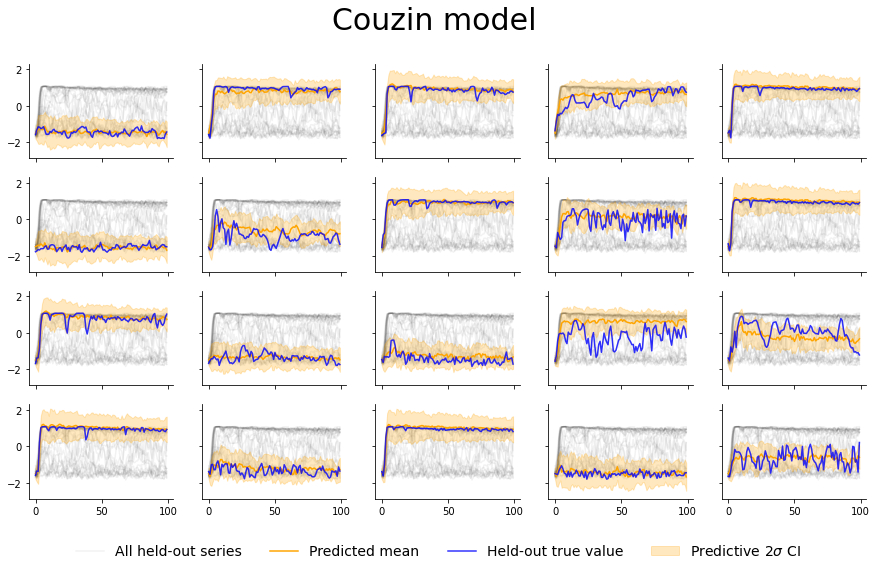

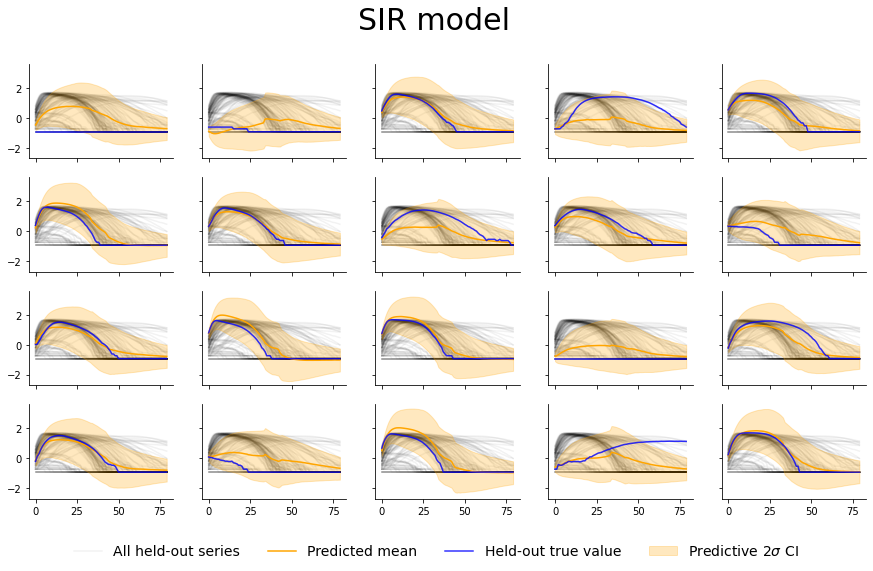

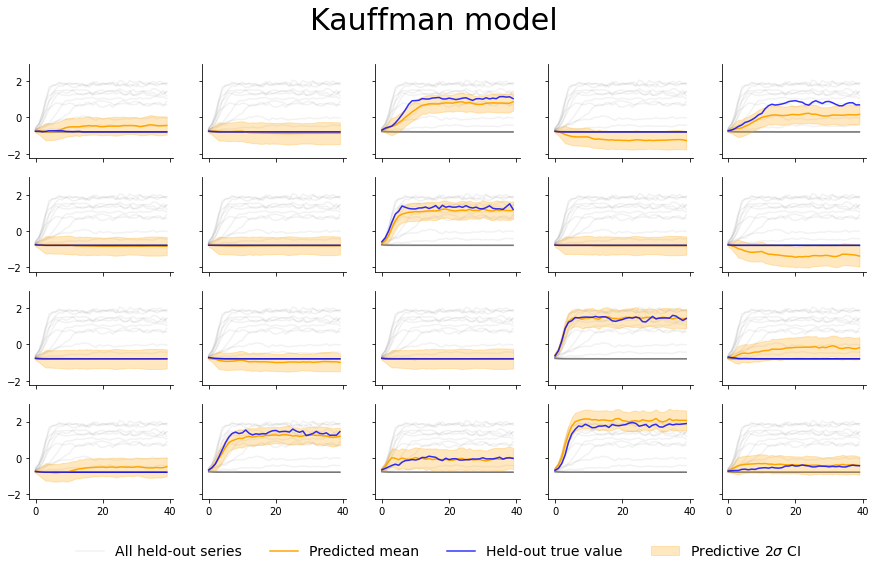

In [10]:
pred_color = 'orange'
test_color = 'b'

nrows = 4
ncols = 5

nsigma = 2

for ds in dataset_names:

    fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=True, figsize=(ncols*3, nrows*2))
    axes      = axes.ravel()
    plt.suptitle(fancy_names[ds], fontsize=30)
    
    pred_mean,       pred_var       = ind_predictions[ds]
    print(ds, pred_mean.max(), pred_var.max())
    pred_mean_train, pred_var_train = ind_predictions_train[ds]

    X_train, X_test, Y_train, Y_test = xy_values[ds]

    pred_sigma       = pred_var**0.5
    pred_sigma_train = pred_var_train**0.5

    for i in range(nrows*ncols):
        xs = np.arange(len(pred_mean[i]))
        
        axes[i].plot(Y_test[0:-1].T, alpha=0.05, color='k', zorder=0)
        axes[i].plot(Y_test[-1].T, alpha=0.05, color='k', zorder=0, label='All held-out series')

        pred_mean_handle = axes[i].plot(pred_mean[i], color=pred_color, label='Predicted mean')
        pred_ci = axes[i].fill_between(xs,
                             pred_mean[i] + nsigma*pred_sigma[i],
                             pred_mean[i] - nsigma*pred_sigma[i],
                             color=pred_color, alpha=0.25,
                             label='Predictive $2\sigma$ CI',zorder=1)
        
        true_handle = axes[i].plot(Y_test[i], color=test_color, alpha=0.8,
                                   label='Held-out true value', zorder=2)

        for spine_loc in ['top', 'right']:
            axes[i].spines[spine_loc].set_visible(False)
            '''axes[i+train_test_offset].spines[spine_loc].set_visible(False)'''
            
    lines_labels  = axes[-1].get_legend_handles_labels()
    lines, labels = lines_labels

    fig.legend(lines, labels, loc='lower center', fontsize=14, ncol=4, frameon=False)
    plt.savefig(figure_dir + f'test-predictions/ind_test_series_{ds}.png', dpi=300)
    

#### Static case

In [ ]:
n_iters_vi   = 10
n_iters_mcmc = 10

traces    = {x:{} for x in dataset_names}

for ds in dataset_names:
    # Standardize all inputs and response variables
    
    outputs = data[ds]['static']

    outputs_means  = outputs.mean()
    outputs_scales = outputs.std()
    outputs_std    = (outputs-outputs_means) / outputs_scales
    constants[ds]['output_scale'] = outputs_scales
    constants[ds]['output_mean']  = outputs_means

    inputs        = data[ds]['params']
    inputs_means  = inputs.mean()
    inputs_scales = inputs.std()
    inputs_std    = (inputs-inputs_means) / inputs_scales
    constants[ds]['param_scale'] = inputs.std()
    constants[ds]['param_mean']  = inputs.mean()
    
    is_train = np.random.binomial(1, training_fraction, size=len(outputs_std)).astype(bool)
    constants[ds]['is_train'] = is_train
    
    X_train, X_test = inputs[is_train], inputs[~is_train]
    Y_train, Y_test = outputs[is_train], outputs[~is_train]
    print('Training data shapes:', X_train.shape, Y_train.shape)
    print('Testing data shapes:',X_test.shape, Y_test.shape)
    
    try:
        X_train = X_train.values
    except:
        pass
    try:
        Y_train = Y_train.values
    except:
        pass    
    try:
        X_test = X_test.values
    except:
        pass    
    
    model, gp = emulator_model(X_train, Y_train, X_test=[])
    
    with model:
        traces[ds]['MAP']   = pm.find_MAP()
        traces[ds]['VI']    = pm.fit(n=n_iters_vi).sample(4000)
        traces[ds]['MCMC']  = pm.sample(tune=n_iters_mcmc, draws=n_iters_mcmc, target_accept = 0.95)